In [2]:
#@title Load Packages
# TYPE HINTS
from typing import Tuple, Optional, Dict, Callable, Union

# PyTorch Settings
import torch

# Pyro Settings

# GPyTorch Settings
import gpytorch

# PyTorch Lightning Settings

# NUMPY SETTINGS
import numpy as np
np.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)
# sns.set(rc={'figure.figsize': (12, 9.)})
# sns.set_style("whitegrid")

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)



In [3]:
def regression_near_square(
    n_train: int = 50,
    n_test: int = 1_000,
    x_noise: float = 0.3,
    y_noise: float = 0.2,
    seed: int = 123,
    buffer: float = 0.1,
):
    rng = np.random.RandomState(seed)

    # function
    f = lambda x: np.sin(1.0 * np.pi / 1.6 * np.cos(5 + 0.5 * x))

    # input training data (clean)
    xtrain = np.linspace(-10, 10, n_train).reshape(-1, 1)
    ytrain = f(xtrain) + rng.randn(*xtrain.shape) * y_noise
    xtrain_noise = xtrain + x_noise * rng.randn(*xtrain.shape)

    # output testing data (noisy)
    xtest = np.linspace(-10.0 - buffer, 10.0 + buffer, n_test)[:, None]
    ytest = f(xtest)
    xtest_noise = xtest + x_noise * rng.randn(*xtest.shape)

    idx_sorted = np.argsort(xtest_noise, axis=0)
    xtest_noise = xtest_noise[idx_sorted[:, 0]]
    ytest_noise = ytest[idx_sorted[:, 0]]

    return xtrain, xtrain_noise, ytrain, xtest, xtest_noise, ytest, ytest_noise

In [4]:
n_train = 60
n_test = 100
x_noise = 0.1
y_noise = 0.05
seed = 123


(
    Xtrain,
    Xtrain_noise,
    ytrain,
    xtest,
    xtest_noise,
    ytest,
    ytest_noise,
) = regression_near_square(
    n_train=n_train, n_test=n_test, x_noise=x_noise, y_noise=0.05, seed=123, buffer=0.3
)

x_stddev = np.array([x_noise])

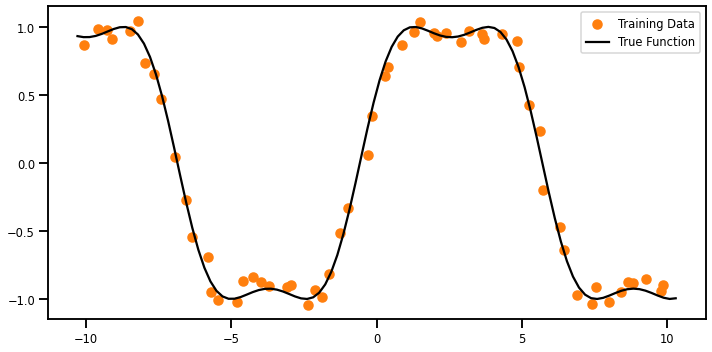

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(Xtrain_noise, ytrain, color="tab:orange", label="Training Data")
ax.plot(xtest, ytest, color="black", label="True Function")
ax.legend()
plt.tight_layout()
plt.show()

In [6]:
xtrain_tensor = torch.Tensor(Xtrain_noise)
ytrain_tensor = torch.Tensor(ytrain.squeeze())
xtest_tensor = torch.Tensor(xtest_noise)
ytest_tensor = torch.Tensor(ytest_noise)

In [7]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

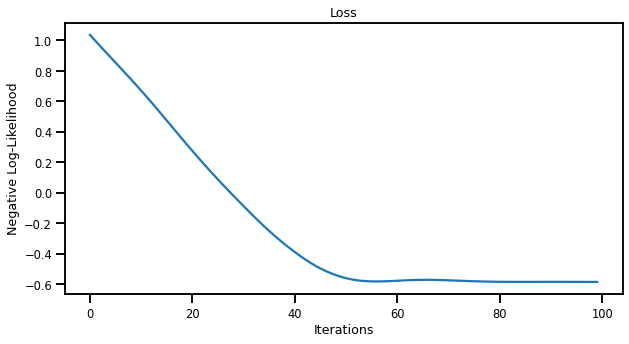

In [9]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(xtrain_tensor, ytrain_tensor, likelihood)
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
losses = []
training_iter = 100

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(xtrain_tensor)
    # Calc loss and backprop gradients
    loss = -mll(output, ytrain_tensor)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(losses)
ax.set(title="Loss", xlabel="Iterations", ylabel="Negative Log-Likelihood")
plt.show()

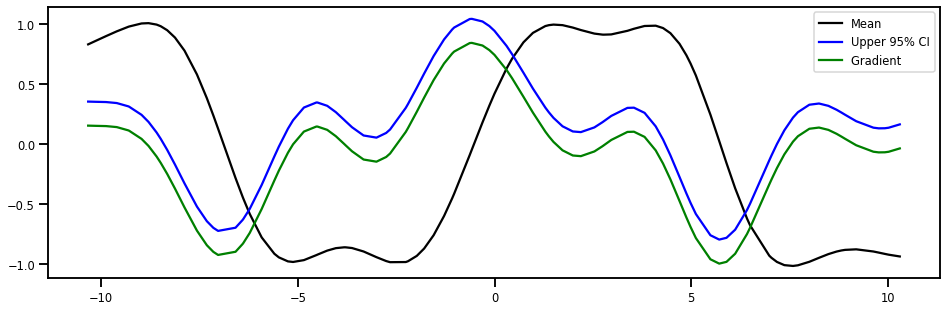

In [34]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(xtest_tensor))
    mu = observed_pred.mean.cpu().numpy()
    var = observed_pred.variance.cpu().numpy()
    std = np.sqrt(var.squeeze())

X = torch.autograd.Variable(xtest_tensor.clone().detach(), requires_grad=True)
def _mean_f(X):
    return model(X).mean.sum()
x_grad  = torch.autograd.grad(_mean_f(X), X)[0]
df_std = torch.ones(size=x_grad.size()).detach().numpy()/10

fig, ax = plt.subplots(figsize=(16,5))
ax.plot(xtest_tensor.detach().numpy(), mu, color="black", label="Mean")
ax.plot(xtest_tensor.detach().numpy(), x_grad.detach().numpy()+2*df_std.reshape((-1,1)), color="blue", label="Upper 95% CI")
ax.plot(xtest_tensor.detach().numpy(), x_grad.detach().numpy(), 'green', label="Gradient ")
plt.legend()
plt.show()

In [31]:
model.eval()
likelihood.eval()

def d2K(X):
    def K_xx(X1,X2):
        full_inputs = torch.cat([X1, X2], dim=-2)

        # Get the joint distribution for training/test data
        full_output = model(full_inputs)
        full_covar = full_output.covariance_matrix
        K = full_covar[:X1.size(0),X1.size(0):]
        return K

    def dK_x(X1, X2):
        results = torch.autograd.grad(K_xx(X1,X2), X1, create_graph=True)[0]
        return results

    n = X.shape[0]
    d = X.shape[1]
    results = torch.zeros((n,d))
    for i in range(1,n):
        x1 = X[i,:].clone().detach().requires_grad_(True).reshape((1,d))
        x2 = X[i,:].clone().detach().requires_grad_(True).reshape((1,d))
        results[i,:] = torch.autograd.grad(dK_x(x1, x2).sum(), x2, create_graph=True)[0]
    return results

K_hessian = d2K(X)
df_std = K_hessian.sqrt().detach().numpy()

In [139]:
model.eval()
likelihood.eval()

def d2K(X1, X2):
    def K_xx(X1, X2):
        full_inputs = torch.cat([X1, X2], dim=-2)

        # Get the joint distribution for training/test data
        full_output = model(full_inputs)
        full_covar = full_output.covariance_matrix
        K = full_covar[:1,1:]
        return K

    def dK_x(X1, X2):
        return torch.autograd.grad(K_xx(X1,X2), X1, create_graph=True)[0]

    n = X1.shape[0]
    m = X2.shape[0]
    results = torch.zeros((n,m))
    for i in range(n):
        for j in range(m):
            x1 = X1[i,:].reshape((1,1))
            x2 = X2[j,:].reshape((1,1))
            results[i,j] = torch.autograd.grad(dK_x(x1,x2), x2, create_graph=True)[0]
    return results

X1 = torch.tensor(xtrain_tensor, requires_grad=True)

K_hessian = d2K(X,X)

# K_grad = var_df(X[40,:].reshape((1,1)))[0,:,0,:]
# print(K_grad.shape)

# def var_f_p(X):
#     # Get the joint distribution for training/test data
#     full_output = model(X)
#     full_covar = full_output.covariance_matrix
#     K_xX = full_covar.diagonal().sum()
#     return K_xX

# K_p = torch.autograd.functional.hessian(var_f_p, X, create_graph=True)[:,0,:,0].diagonal()
# print(K_p)


/Users/yahoo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [33]:
df_std[:,0]

array([0.   , 0.165, 0.118, 0.084, 0.063, 0.062, 0.055, 0.053, 0.052,
       0.052, 0.052, 0.053, 0.053, 0.051, 0.049, 0.048, 0.047, 0.048,
       0.049, 0.05 , 0.051, 0.051, 0.05 , 0.049, 0.047, 0.047, 0.048,
       0.05 , 0.051, 0.052, 0.052, 0.051, 0.05 , 0.049, 0.048, 0.048,
       0.048, 0.049, 0.05 , 0.051, 0.052, 0.052, 0.051, 0.049, 0.048,
       0.047, 0.047, 0.047, 0.05 , 0.052, 0.052, 0.052, 0.051, 0.048,
       0.046, 0.048, 0.049, 0.049, 0.051, 0.051, 0.05 , 0.047, 0.047,
       0.047, 0.049, 0.049, 0.052, 0.052, 0.05 , 0.047, 0.047, 0.047,
       0.049, 0.051, 0.051, 0.051, 0.05 , 0.049, 0.048, 0.048, 0.049,
       0.049, 0.05 , 0.051, 0.051, 0.05 , 0.05 , 0.05 , 0.051, 0.054,
       0.057, 0.058, 0.057, 0.056, 0.057, 0.102, 0.126, 0.157, 0.176,
       0.234], dtype=float32)